In [42]:
# from networkx.drawing.nx_agraph import write_dot, graphviz_layout
import itertools
import numpy as np
import seaborn as sns
from operator import itemgetter
# from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt
import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.centrality import edge_betweenness_centrality
# import pandas as pd
import collections
from networkx.algorithms import community

Some of these graphs are inspired from the sample ones provided by the networkx library

In [3]:
from scipy.cluster.hierarchy import dendrogram
G = nx.read_edgelist("p2p-Gnutella31.txt", create_using=nx.Graph(), nodetype=int)
G.name = "Gnutella August 31 - Big"
G_small = nx.read_edgelist("p2p-Gnutella08.txt", create_using=nx.Graph(), nodetype=int)
G_small.name = "Gnutella August 08 - Small"
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]
S_small = [G_small.subgraph(c).copy() for c in nx.connected_components(G_small)]

In [23]:
print(nx.info(G))
print(nx.info(G_small))

Name: Gnutella August 31 - Big
Type: Graph
Number of nodes: 62586
Number of edges: 147892
Average degree:   4.7260
Name: Gnutella August 08 - Small
Type: Graph
Number of nodes: 6301
Number of edges: 20777
Average degree:   6.5948


In [26]:
for i, g in enumerate(S):
    print(f'Subgraph #{i} - Diameter: {nx.diameter(g)}')

KeyboardInterrupt: 

In [ ]:
# title = ""
# plt.title(title + ' Layout')
# pos = graphviz_layout(G, prog='dot')
# nx.draw(G, pos, with_labels=True, arrows=True)
# # plt.figure(figsize=(10, 6))
# plt.savefig(title.split()[0].lower() + '-layout.png')
# plt.close()

Average path length
Clustering coefficient
Giant Connected component

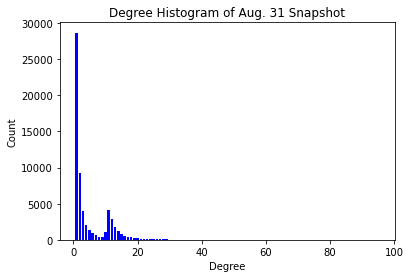

In [32]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram of Aug. 31 Snapshot")
plt.ylabel("Count")
plt.xlabel("Degree")
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

# draw graph in inset
# plt.axes([0.4, 0.4, 0.5, 0.5])
# Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
# pos = nx.spring_layout(G)
# plt.axis("off")
# nx.draw_networkx_nodes(G, pos, node_size=20)
# nx.draw_networkx_edges(G, pos, alpha=0.4)
plt.savefig('degreeHist1.png')
plt.show()


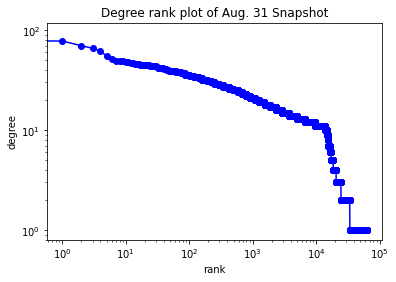

In [35]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
dmax = max(degree_sequence)

plt.loglog(degree_sequence, "b-", marker="o")
plt.title("Degree rank plot of Aug. 31 Snapshot")
plt.ylabel("degree")
plt.xlabel("rank")

plt.savefig("degreeRankPlot.png")
plt.show()

In [ ]:
# plt.axes([0.45, 0.45, 0.45, 0.45])
# Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
# pos = nx.spring_layout(Gcc)
# plt.axis("off")
# nx.draw_networkx_nodes(Gcc, pos, node_size=20)
# nx.draw_networkx_edges(Gcc, pos, alpha=0.4)
# plt.show()

In [ ]:
[nx.average_shortest_path_length(s) for s in S]

In [64]:
k = 10
August8 = list(edge_betweenness_centrality(G_small, k = k).values())
August31 = list(edge_betweenness_centrality(G, k = k).values())
y = [np.log10(August8), np.log10(August31)]

C:\Users\smarty\miniconda3\envs\graph-mining\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


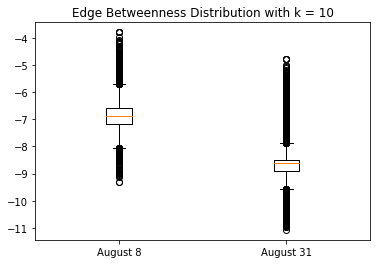

In [65]:
ax = plt.axes()
plt.boxplot(y)
plt.ylabel = "Log of Edge Betweenness Centrality"
ax.set_xticklabels(["August 8", "August 31"])
plt.title(f"Edge Betweenness Distribution with k = {k}")
plt.savefig('Betweenness.png')
plt.show()

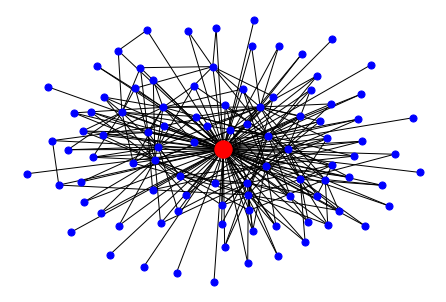

In [7]:
# Not the most creative graph, I know, pretty much straight
# From the networkx gallery, still, the visualization is pretty interesting
# find node with largest degree
node_and_degree = G_small.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

# Create ego graph of main hub
hub_ego = nx.ego_graph(G_small, largest_hub)

# Draw graph
pos = nx.spring_layout(hub_ego)
nx.draw(hub_ego, pos, node_color="b", node_size=50, with_labels=False)

# Draw ego as large and red
options = {"node_size": 300, "node_color": "r"}
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub], **options)

plt.savefig("egoNet.png")
plt.show()

Lots of edge nodes connect directly to ego node

Swarm around him ensures redundancy

In [56]:
giant = max(S, key=len)
print(nx.info(giant))

Name: Gnutella August 31 - Big
Type: Graph
Number of nodes: 62561
Number of edges: 147878
Average degree:   4.7275


In [10]:
nx.average_clustering(max(S_small, key=len))

0.010871372617495094

In [11]:
nx.average_clustering(giant)
# Clustering implies edge locality

0.00546606229489278

In [9]:
nx.average_shortest_path_length(max(S_small, key=len))

4.642991969318119

In [ ]:
clustering_coefs = nx.clustering(G)
clustering_count = collections.Counter(clustering_coefs)
deg, cnt = zip(*clustering_count.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Clustering Coefficient Histogram of Aug. 31 Snapshot")
plt.ylabel("Count")
plt.xlabel("Clustering Coefficient")
# ax.set_xticks([d + 0.4 for d in deg])
# ax.set_xticklabels(deg)

plt.savefig('clusteringHist1.png')
plt.show()

In [12]:
def plot_dendrogram(G, edges, title, ignore_weight=False):
    # Convert edge/bw-scores into Z matrix (linkage matrix)
    uf = nx.utils.UnionFind()
    sz = {x: 1 for x in G.nodes}
    _ = [uf[x] for x in G.nodes]  # Initialize union find with singleton sets
    h = {x: x for x in G.nodes}
    Z = []
    cnt = len(G.nodes)
    j = 1.0
    for (v1, v2, bw) in reversed(edges):  # Agglomerative
        v1 = v1[0] if type(v1) == list else v1  # Enter list if needed
        v2 = v2[0] if type(v2) == list else v2  # Enter list if needed
        if uf[v1] == uf[v2]:
            # Skip edges that don't connect new components
            continue
        nsz = sz[uf[v1]] + sz[uf[v2]]
        # Create the linkage matrix
        w1, w2 = h[uf[v1]], h[uf[v2]]
        Z.append([w1 if w1 < w2 else w2, w2 if w1 < w2 else w1, j if ignore_weight else bw, nsz])
        uf.union(v1, v2)
        sz[uf[v1]] = nsz  # Track cluster size
        h[uf[v1]] = cnt  # Label cluster
        j += 1.0
        cnt += 1
    # Draw the Dendrogram
    fig = plt.figure(figsize=(10, 6))
    Z = np.array(Z)
    dn = dendrogram(Z)
    plt.title(title + " Hierarchical Clustering")
    plt.savefig(title.split()[0].lower() + "-dendrogram" + ("-ref" if "Reference" in title else "-your") + ".png")
    # plt.show()  Uncomment if you want to see the dendrogram
    plt.close()

    return Z

In [13]:
def wrap_bw(H):
    bw = nx.edge_betweenness_centrality(H, normalized=False)
    mx = max(bw.values())
    for e in sorted(bw.keys()):
        if bw[e] == mx:
            return e

In [21]:
giant_small = max(S_small, key=len)

In [ ]:
splits_ref = list(nx.algorithms.community.centrality.girvan_newman(giant_small, most_valuable_edge=wrap_bw))
# Going in reverse, find which groups get merged
df = [[sorted(list(s)) for s in splits_ref[-i] if s not in splits_ref[-i - 1]] for i in range(1, len(splits_ref))]
df += [[[sorted(list(splits_ref[0][0]))[0]], [sorted(list(splits_ref[0][1]))[0]]]]
# Find the subgraphs so we can find betweenness
df = [(df[i][0], df[i][1], i + 1.0) for i in range(len(df))]
Z_ref = plot_dendrogram(giant_small, list(reversed(df)), "Graph" + " - Reference Solution", ignore_weight=True)

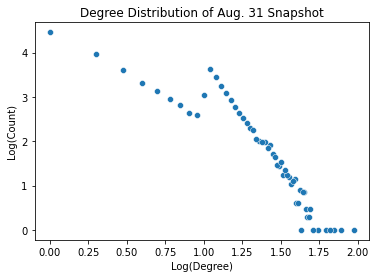

In [28]:
degree_sequence = [d for n, d in G.degree()]
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())
sns.scatterplot(x=np.log10(deg), y=np.log10(cnt))
plt.title("Degree Distribution of Aug. 31 Snapshot")
plt.ylabel("Log(Count)")
plt.xlabel("Log(Degree)")
plt.savefig('degreeloglog.png')
plt.show()

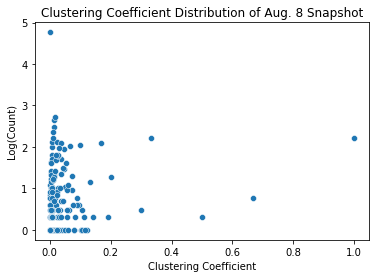

In [19]:
clustering = list(nx.clustering(G).values())
clusterCount = collections.Counter(clustering)
clust, cnt = zip(*clusterCount.items())
sns.scatterplot(x=clust, y=np.log10(cnt))
plt.title("Clustering Coefficient Distribution of Aug. 8 Snapshot")
plt.ylabel("Log(Count)")
plt.xlabel("Clustering Coefficient")
plt.savefig('clustering.png')
plt.show()

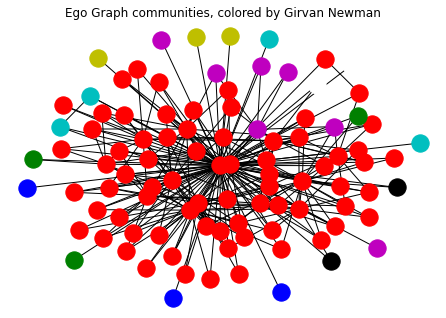

In [61]:
ego = nx.ego_graph(giant_small, max(giant_small.degree(), key=itemgetter(1))[0])
pos = nx.spring_layout(ego)
nx.draw(ego, pos, node_color="b", node_size=50, with_labels=False)
colors = ['r','b','y','c','g','m','k','w']

for t in itertools.islice(girvan_newman(ego), 20,21):
    for i, comm in enumerate(t):
        nx.draw_networkx_nodes(ego, pos, nodelist=comm, node_color=colors[i%len(colors)])
plt.savefig('communities')
plt.title("Ego Graph communities, colored by Girvan Newman")
plt.show()